In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import numpy as np
import glob
import sys
from scipy import io
import math
import keras
from skimage import transform
import random
import tqdm

import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 12]
plt.style.use('ggplot')

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# GLOBALS

In [2]:
POET_DIR = "D:/data/POETdataset/"
pascal_images = os.path.join(POET_DIR, 'PascalImages')
CLASS2IDX_FILE = os.path.join(POET_DIR, 'class2idx.npy')
IDX2CLASS_FILE = os.path.join(POET_DIR, 'idx2class.npy')
PATCH_SIZE = 78
HALF_PATCH = PATCH_SIZE//2
DATASET_SIZE = 6270
VALIDATION_PERC = 0.2
# MAX_GAZE_POINTS = 3 # TEMPORARY
MIN_GAZE_POINTS = 0
BATCH_SIZE = 50
os.chdir(POET_DIR)

In [3]:
os.chdir(POET_DIR)

# PATCH EXTRACTION 

In [4]:
classes = [a.split("_")[1].split(".mat")[0] for a in glob.glob("etData/*")]
idx2class = {i:c for i, c in enumerate(classes)}
class2idx = {c:i for i, c in enumerate(classes)}

In [5]:
def fixation_within_image(fx, fy, dims):
#   print(dims)
  if fx < 0:
    return False
  if fx > dims[1]:
    return False
  if fy < 0:
    return False
  if fy > dims[0]:
    return False

  return True

In [6]:
import pdb

In [7]:
def get_avg_fixations(fixR, fixL, dims):
    # ger average of fixations between right and left eye
    # manage nans
    fix = []
    for i in range(len(fixR)):
        fR = fixR[i]
        fL = fixL[i]
        fx = None
        fy = None
        # no fixations outside
        if not np.isnan(fR[0]) and not np.isnan(fL[0]):
            fx = np.mean([fR[0],fL[0]])
        else:
            if np.isnan(fR[0]):
                fx = fL[0]
            elif np.isnan(fL[0]):
                fx = fR[0]
                
        if not np.isnan(fR[1]) and not np.isnan(fL[1]):
            fy = np.mean([fR[1],fL[1]])
        else:
            if np.isnan(fR[1]):
                fy = fL[1]
            elif np.isnan(fL[1]):
                fy = fR[1]
        if fixation_within_image(fx, fy, dims):
            fix.append([fx,fy])

    fix = np.array(fix)
    return fix

In [8]:
class_matrices = {}

In [9]:
def get_fixations(filename, classname, dims):
    filename = filename.split("%s_" %classname)[1]
    filename = filename.split('.')[0]
    if classname not in class_matrices.keys():
        c_instances = io.loadmat(os.path.join(POET_DIR,'etData','etData_%s.mat' %classname), squeeze_me=True)['etData']
        class_matrices[classname] = c_instances
    else:
        c_instances = class_matrices[classname]

    for i in c_instances:
        if filename == i['filename']:
            all_f = []
            all_rt = i['rt']
            for u_i in range(len(i['rt'])):
                fixR = i['fixations'][u_i]['imgCoord']['fixR'].tolist()['pos'].tolist().tolist()
                fixL = i['fixations'][u_i]['imgCoord']['fixL'].tolist()['pos'].tolist().tolist()
                if len(fixR) > 0 and len(fixL) > 0:
                    if type(fixR[0]) is list and type(fixL[0]) is list:
                        fix = get_avg_fixations(fixR, fixL, dims)
                        all_f.append(fix)
            return all_f, all_rt

In [10]:
def gen_patches(filename, classname):
    img_src = keras.preprocessing.image.img_to_array(
        keras.preprocessing.image.load_img(filename)
    )

    fix = get_fixations(filename, classname, (img_src.shape[0], img_src.shape[1]))
    if fix is None:
        return None

    return fix

# STORE ALL PATCHES

In [11]:
test_ids = np.load("test_ids.pkl")
train_ids = np.load("train_ids.pkl")

In [12]:
filenames = [os.path.abspath(os.path.join(pascal_images, f)) for f in np.concatenate([train_ids,test_ids])]

In [13]:
len(filenames)

6131

### Duplicates

In [14]:
unique_ids = ["_".join(f.split("_")[1:]) for f in filenames]

In [15]:
len(set(unique_ids)), len(filenames)

(6131, 6131)

In [16]:
total_instances = len(filenames)

In [17]:
all_fixations_list = []
all_labels_list = []

dropped_list = []
ids = []
duplicates = 0
max_nr_of_fixations = 0
rts = [] # response times
for i, fn in enumerate(tqdm.tqdm(filenames)):
    unique_fn = "_".join(fn.split("_")[1:])
    class_found = False
    if unique_fn not in ids:
        for cname in classes:
            if cname in fn:
                class_found = True
                patches, rt = gen_patches(fn, cname)
                if patches is not None and len(patches)>0:
                    if len(patches) > max_nr_of_fixations:
                        max_nr_of_fixations = len(patches)
                    all_fixations_list.append(patches)
                    all_labels_list.append(class2idx[cname])
                    rts.append(rt)
                    ids.append(unique_fn)
    else:
        duplicates += 1
        
all_fixations_list = np.array(all_fixations_list)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6131/6131 [00:41<00:00, 146.91it/s]


In [18]:
duplicates + len(dropped_list) + len(all_fixations_list)

6131

In [19]:
len(all_fixations_list), len(all_labels_list)

(6131, 6131)

In [20]:
len(rts)

6131

# Plot example image with fixations from all users

In [21]:
name = os.path.abspath(os.path.join(pascal_images, "motorbike_2008_000378.jpg"))

In [22]:
name

'D:\\data\\POETdataset\\PascalImages\\motorbike_2008_000378.jpg'

In [21]:
[i for i,f in enumerate(filenames) if '2010_000439.jpg' in f]

[17]

In [24]:
[i ]

[6130]

D:\data\POETdataset\PascalImages\cat_2010_000439.jpg
cat


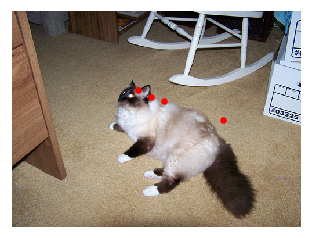

In [28]:
index = 17
plt.imshow(keras.preprocessing.image.img_to_array(
        keras.preprocessing.image.load_img(filenames[index])
    )/255)
print(filenames[index])
print(idx2class[all_labels_list[index]])
colours = ['r','b','g','magenta','yellow']
for i,fix in enumerate(all_fixations_list[index][1:]):
    fix = np.array(fix)
    plt.scatter(fix[:,0],fix[:,1],c=colours[i])
    break
plt.xticks([])
plt.yticks([])
plt.gcf().savefig('image.png', bbox_inches='tight')

# Statistics

- avg nr fix per class per image

- nr of imgs per class

- avg time per class per image

In [26]:
class_avg_nr_fix = {}

for class_id in np.unique(all_labels_list):
    class_indexes = np.where(all_labels_list==class_id)
    class_imgs = all_fixations_list[class_indexes]
    total_class = 0
    for i in class_imgs:
        avg_per_user_for_img = 0
        for u_fix in i:
            avg_per_user_for_img += len(u_fix)
        avg_per_user_for_img = avg_per_user_for_img/len(i)
        total_class += avg_per_user_for_img
    class_mean_nr_fix = total_class/len(class_imgs)
    class_avg_nr_fix[idx2class[class_id]] = class_mean_nr_fix

In [27]:
class_avg_nr_fix.values()

dict_values([3.160210210210212, 3.367542213883679, 3.489980158730158, 3.1554866412213736, 3.737288135593221, 3.162658227848099, 3.282296650717709, 3.5617647058823527, 3.091382765531065, 3.240095986038395])

D:\data\POETdataset\fixations_per_class.png


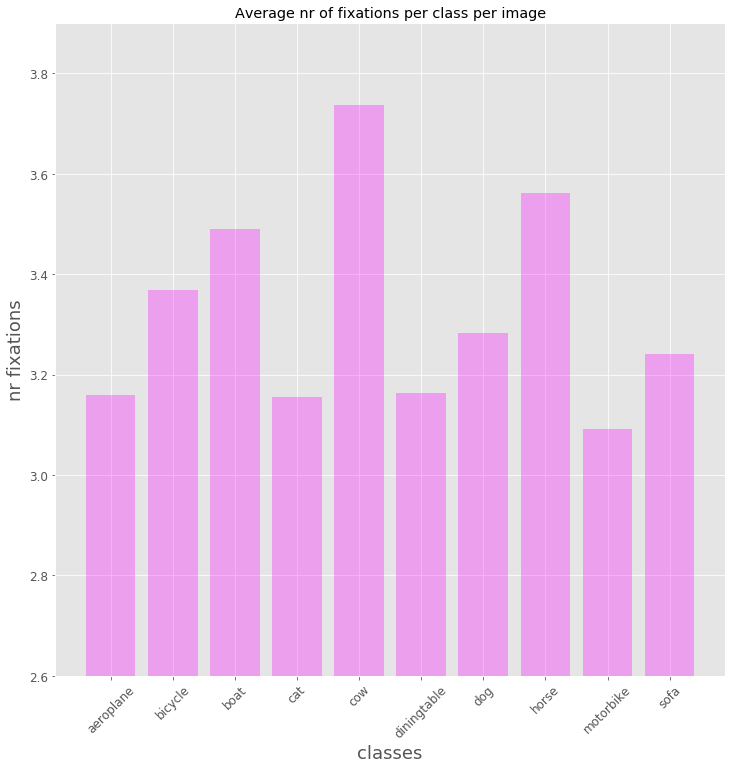

In [28]:
plt.figure(figsize=(12,12))
plt.bar(class_avg_nr_fix.keys(),class_avg_nr_fix.values(), color='fuchsia', alpha=0.3)
plt.ylim(2.6,3.9)
plt.ylabel("nr fixations",fontsize=18)
plt.xlabel('classes', fontsize=18)
plt.title("Average nr of fixations per class per image")
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='x', rotation=45)
path = os.path.abspath("fixations_per_class.png")
print(path)
plt.gcf().savefig(path, bbox_inches="tight")

# Class distribution

In [29]:
from collections import Counter

In [30]:
c = Counter(all_labels_list)

In [31]:
c = dict(c)

D:\data\POETdataset\class_distribution.png


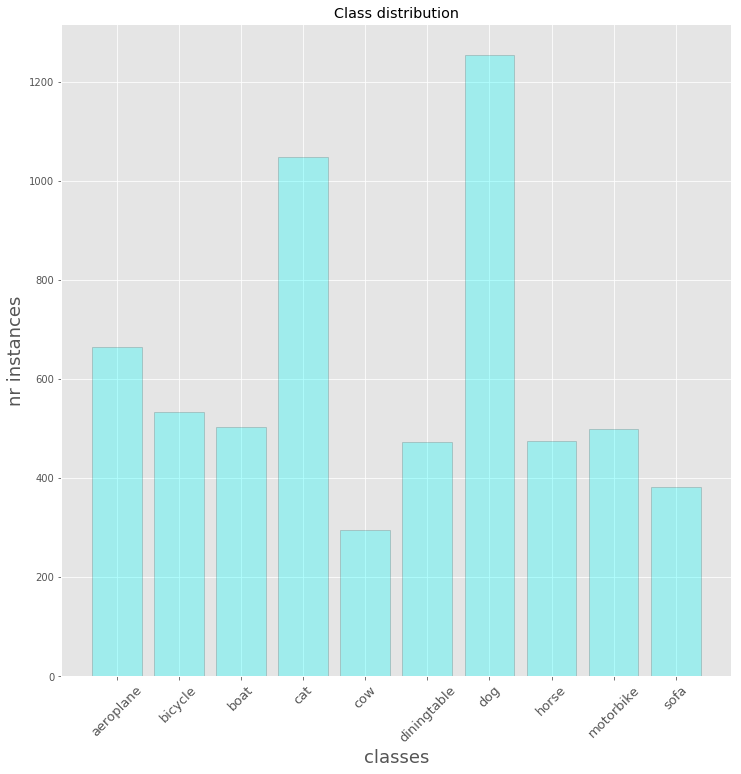

In [32]:
plt.figure(figsize=(12,12))
plt.bar(classes, [c[class2idx[label]] for label in classes], color='cyan', alpha=0.3, edgecolor='black')
plt.xticks(np.arange(len(classes)), classes, rotation=45, fontsize=13)
plt.ylabel("nr instances",fontsize=18)
plt.xlabel('classes', fontsize=18)
plt.title("Class distribution")
path = os.path.abspath("class_distribution.png")
print(path)
plt.gcf().savefig(path, bbox_inches="tight")

# Response times per class

In [33]:
rts = np.array(rts)

In [34]:
class_avg_rt = {}

for class_id in np.unique(all_labels_list):
    class_indexes = np.where(all_labels_list==class_id)
    class_rts = rts[class_indexes]
    total_class = 0
    for i in class_rts:
        avg_per_user_for_img = 0
        for u_rt in i:
            avg_per_user_for_img += u_rt
        avg_per_user_for_img = avg_per_user_for_img/len(i)
        total_class += avg_per_user_for_img
    class_mean_rts = total_class/len(class_rts)
    class_avg_rt[idx2class[class_id]] = class_mean_rts

In [35]:
class_avg_rt.values()

dict_values([0.8603346451230964, 0.8712680433702883, 0.9470552060879767, 0.7861564181032454, 1.0766902218151109, 0.8542645751670934, 0.8111557193442036, 0.9897659243570411, 0.8365284504687542, 0.838423448292924])

D:\data\POETdataset\response_times.png


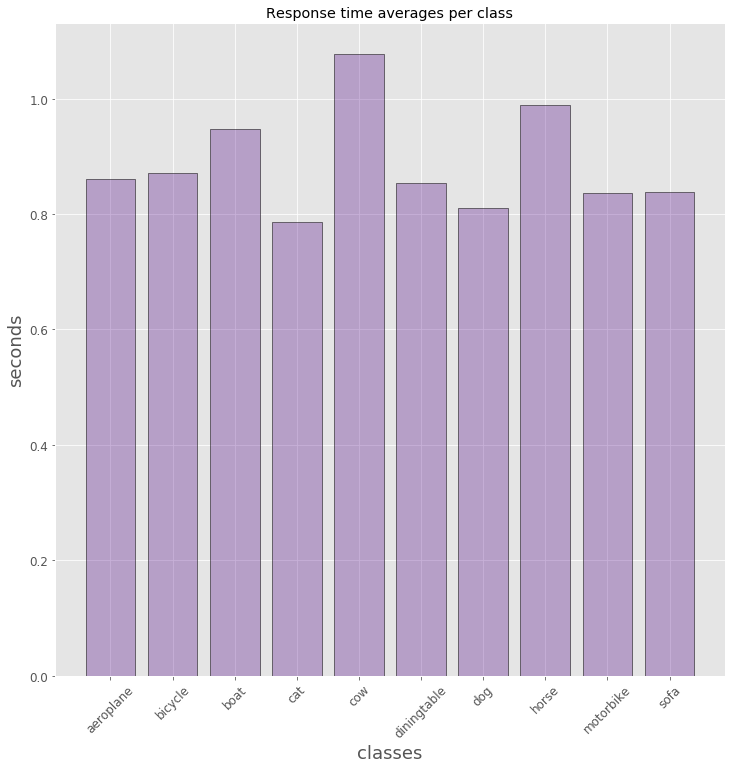

In [36]:
plt.figure(figsize=(12,12))
plt.bar(class_avg_rt.keys(),class_avg_rt.values(), color=(75/255,0/255,130/255,0.3), edgecolor='black')
plt.ylabel("seconds", fontsize=18)
plt.xlabel('classes', fontsize=18)
plt.title("Response time averages per class")
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='x', rotation=45)
path = os.path.abspath("response_times.png")
print(path)
plt.gcf().savefig(path, bbox_inches="tight")

# LSTM model performance by patch size

In [37]:
models = glob.glob("2-*acc*")

In [38]:
models

['2-110-acc 0.8779',
 '2-130-acc 0.8958',
 '2-150-acc 0.9169',
 '2-170-acc 0.9186',
 '2-30-acc 0.5765',
 '2-40-acc 0.6384',
 '2-50-acc 0.7020',
 '2-60-acc 0.7296',
 '2-70-acc 0.7899',
 '2-78-acc 0.8534',
 '2-90-acc 0.8583']

In [39]:
accs = []
p_sizes = []

for m in models:
    accs.append(float(m.split("acc")[-1]))
    p_sizes.append(int(m.split("-")[1]))
    

In [40]:
plt.style.use('ggplot')

In [41]:
p_sizes, accs

([110, 130, 150, 170, 30, 40, 50, 60, 70, 78, 90],
 [0.8779,
  0.8958,
  0.9169,
  0.9186,
  0.5765,
  0.6384,
  0.702,
  0.7296,
  0.7899,
  0.8534,
  0.8583])

In [42]:
sort_indexes = np.argsort(p_sizes)

In [43]:
p_sizes = np.array(p_sizes)[sort_indexes]
accs = np.array(accs)[sort_indexes]

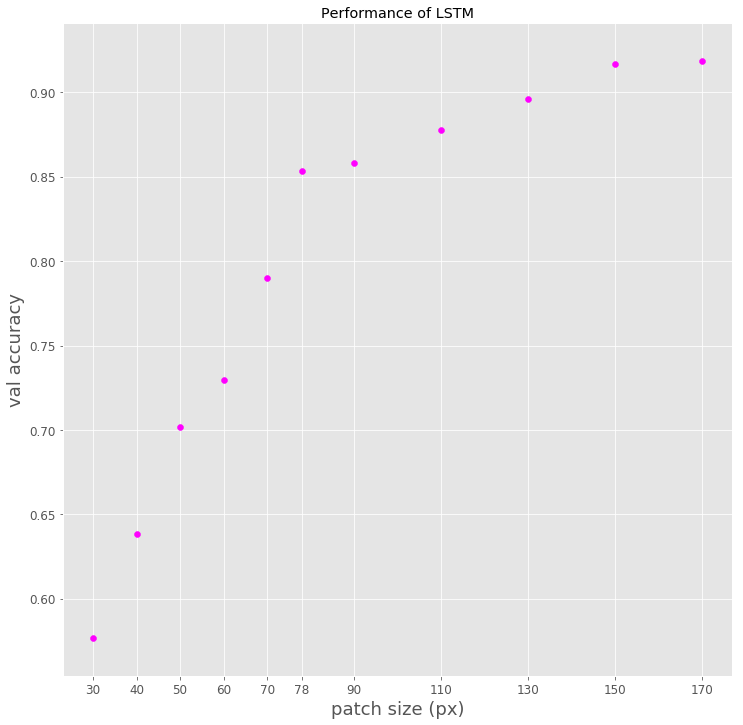

In [51]:
plt.figure(figsize=(12,12))
plt.scatter(p_sizes,accs,c='magenta')
plt.title("Performance of LSTM")
plt.ylabel("val accuracy", fontsize=18)
plt.xlabel("patch size (px)", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(p_sizes)
plt.gcf().savefig("lstm_performance_patch_size.png", bbox='tight')
plt.show()

# LSTM confusion matrices

In [45]:
import itertools
from sklearn.metrics import confusion_matrix

Normalized confusion matrix (patch size = 110)
saving to  2-110-acc 0.8779\model-110-cnf_matrix.png
Normalized confusion matrix (patch size = 130)
saving to  2-130-acc 0.8958\model-130-cnf_matrix.png
Normalized confusion matrix (patch size = 150)
saving to  2-150-acc 0.9169\model-150-cnf_matrix.png
Normalized confusion matrix (patch size = 170)
saving to  2-170-acc 0.9186\model-170-cnf_matrix.png
Normalized confusion matrix (patch size = 30)
saving to  2-30-acc 0.5765\model-30-cnf_matrix.png
Normalized confusion matrix (patch size = 40)
saving to  2-40-acc 0.6384\model-40-cnf_matrix.png
Normalized confusion matrix (patch size = 50)
saving to  2-50-acc 0.7020\model-50-cnf_matrix.png
Normalized confusion matrix (patch size = 60)
saving to  2-60-acc 0.7296\model-60-cnf_matrix.png
Normalized confusion matrix (patch size = 70)
saving to  2-70-acc 0.7899\model-70-cnf_matrix.png
Normalized confusion matrix (patch size = 78)
saving to  2-78-acc 0.8534\model-78-cnf_matrix.png
Normalized confusi

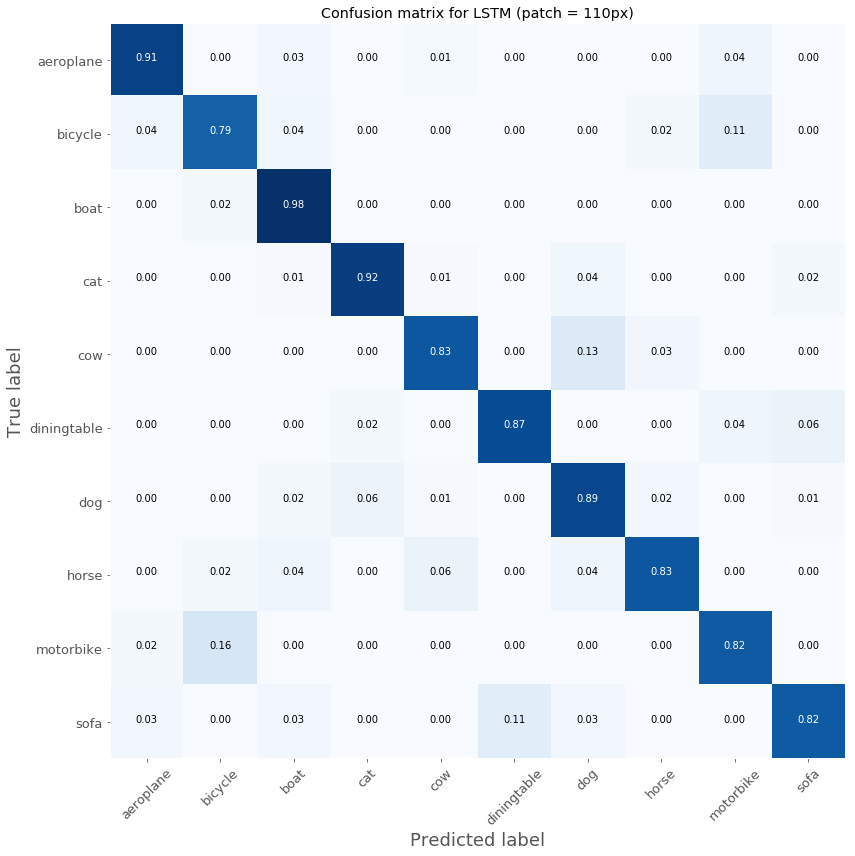

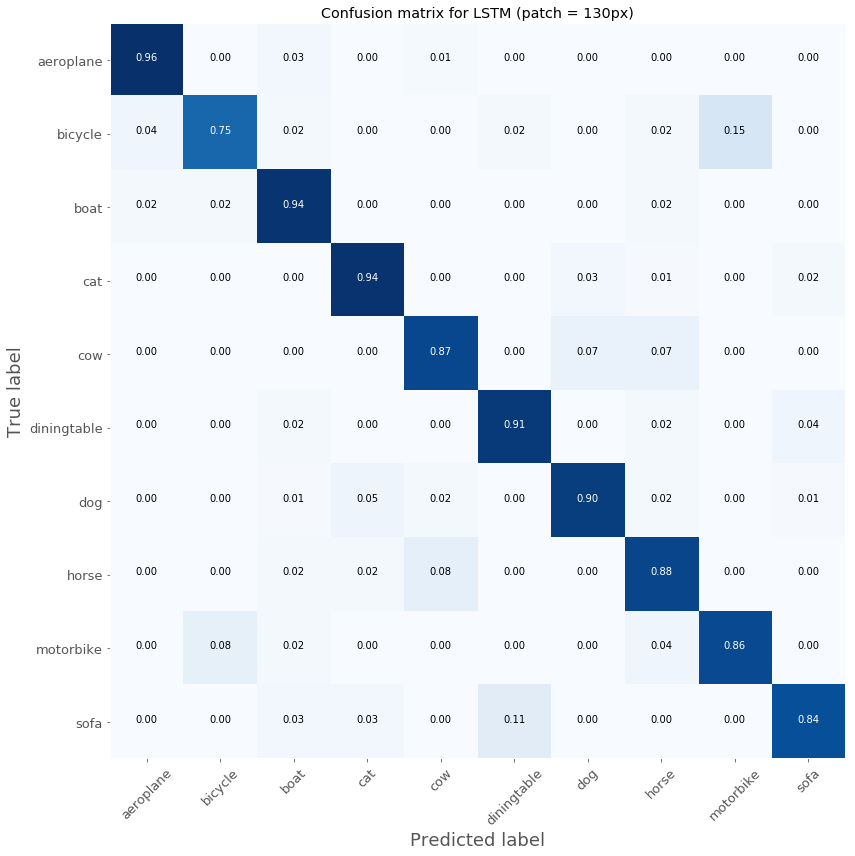

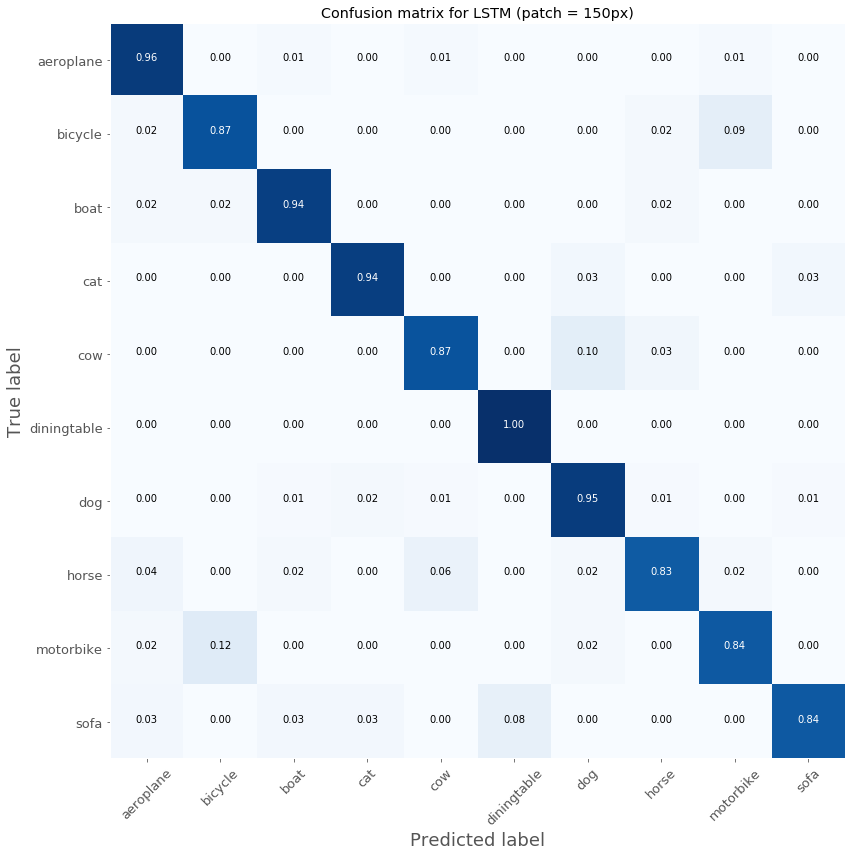

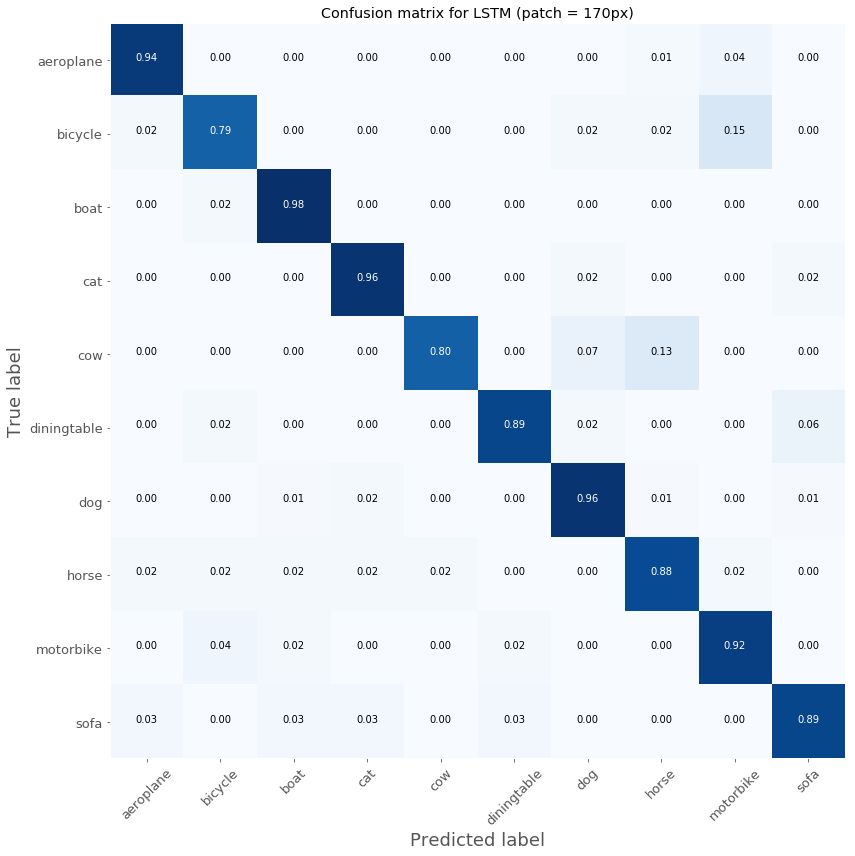

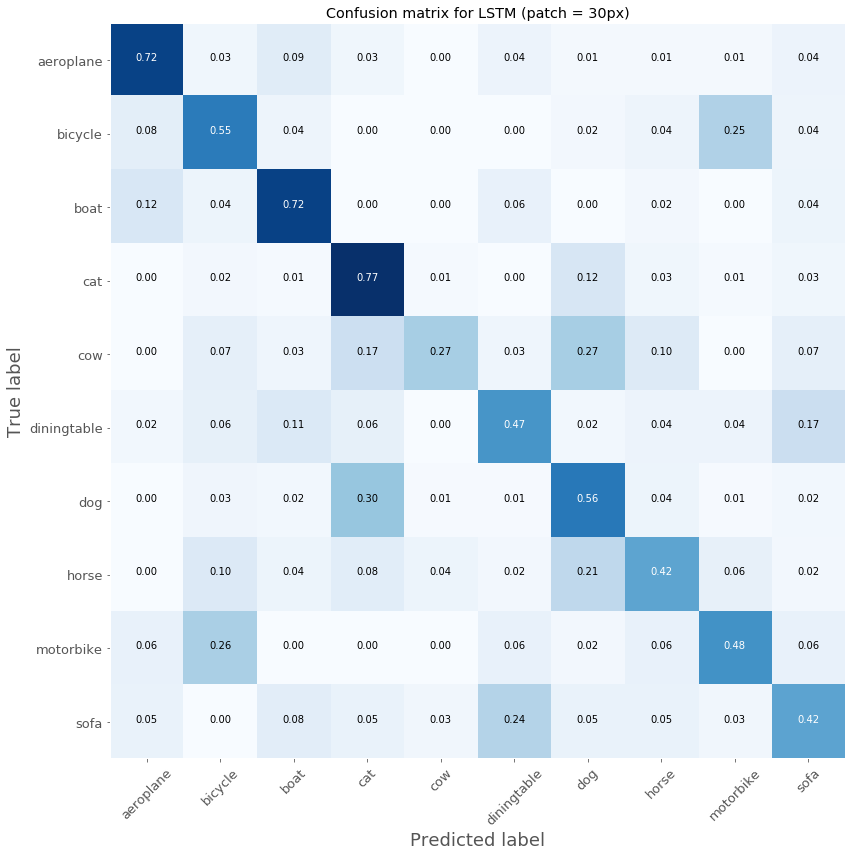

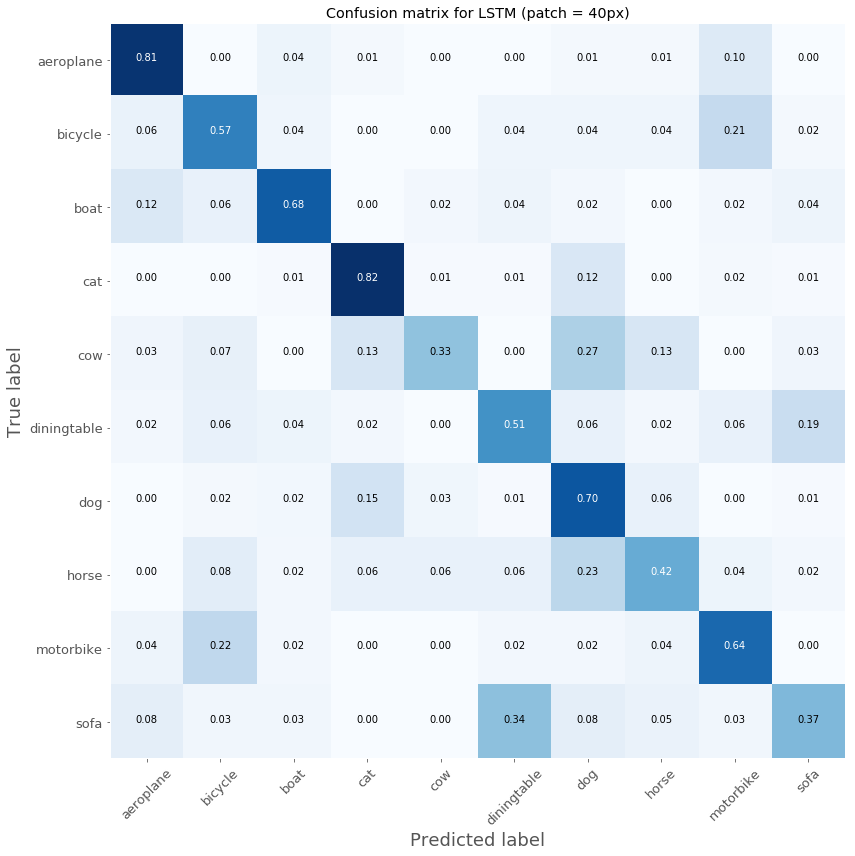

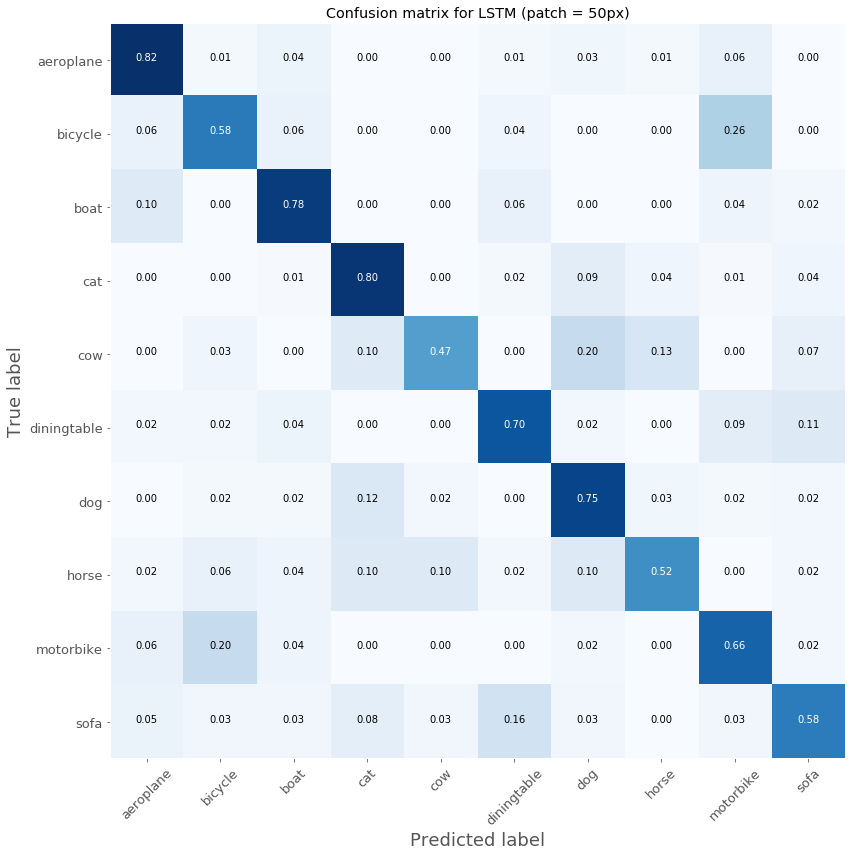

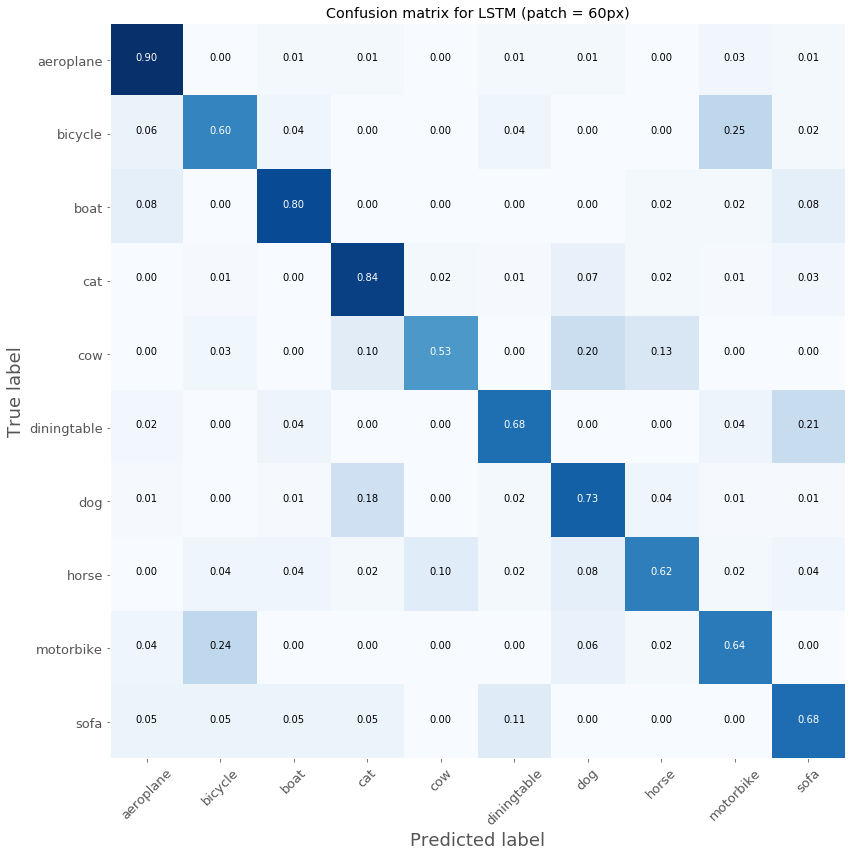

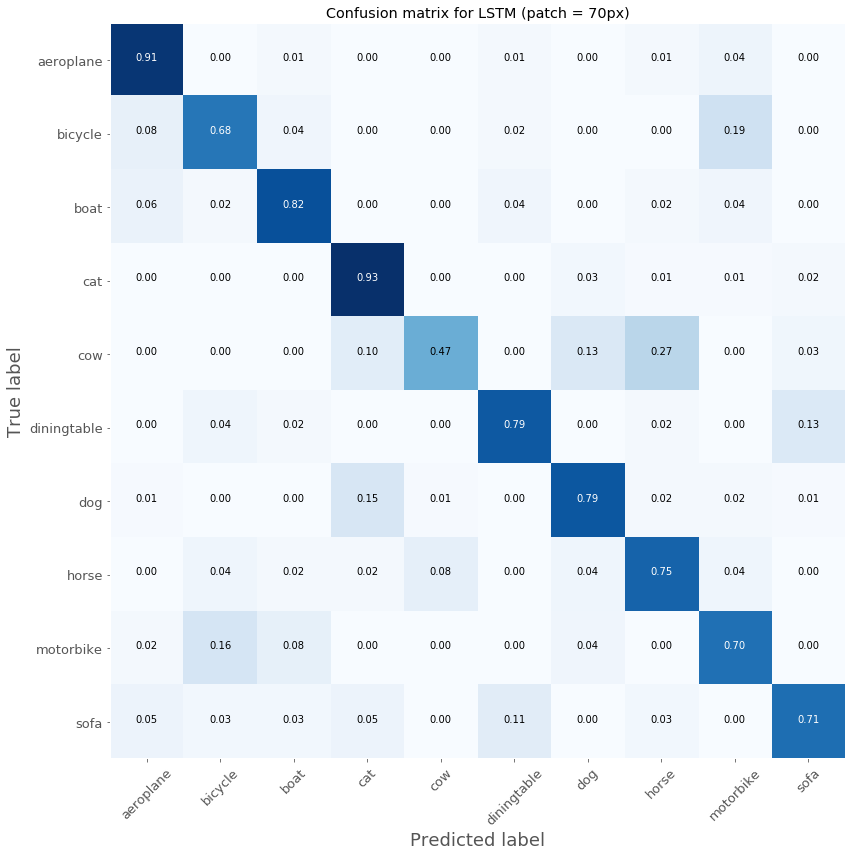

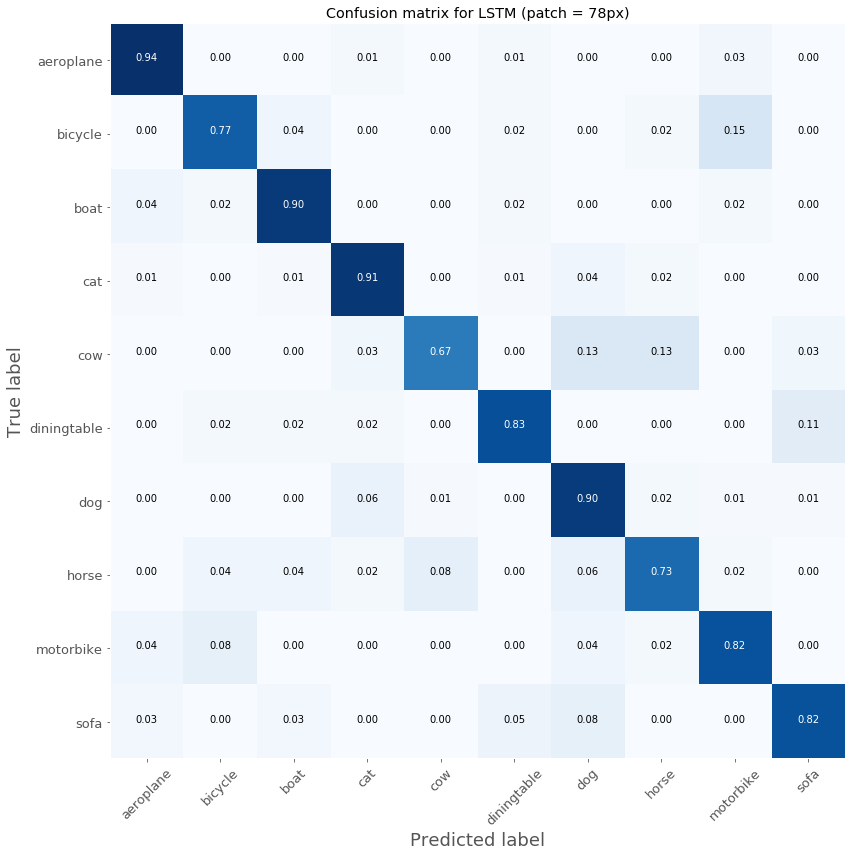

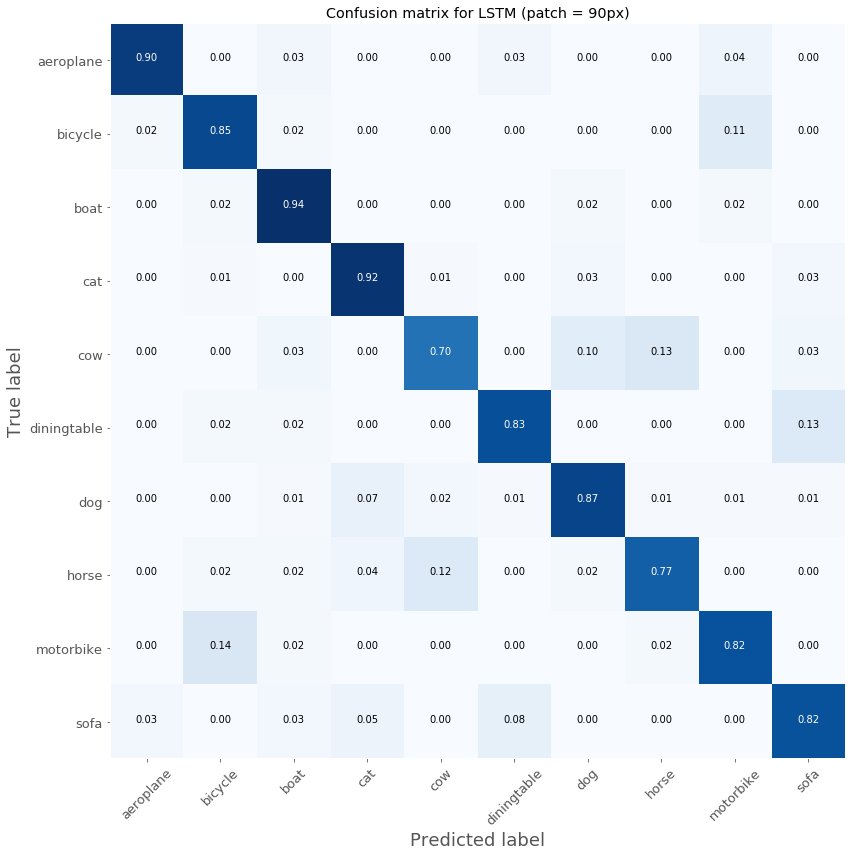

In [46]:
classes = list(np.load("class2idx.npy").tolist().keys())

def plot_confusion_matrix(cm, classes, patch_size,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix (patch size = %s)" %patch_size)
    else:
        print('Confusion matrix, without normalization')

#     print(cm)
    plt.figure(figsize=(12,12))
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix for LSTM (patch = %spx)' %patch_size)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.tight_layout()
    plt.grid(False)
    return plt.gcf()

for model_folder in models:
    confusion_matrix = np.load(os.path.join(model_folder,'model-cnf_matrix.npy'))
    p_size = int(model_folder.split("-")[1])
    fig = plot_confusion_matrix(confusion_matrix, classes,p_size,normalize=True)
    if os.path.exists(os.path.join(model_folder,"model-cnf_matrix.png")):
        os.remove(os.path.join(model_folder,"model-cnf_matrix.png"))
    fig.savefig(os.path.join(model_folder,'model-%s-cnf_matrix.png' %p_size))
    print('saving to ', os.path.join(model_folder,'model-%s-cnf_matrix.png' %p_size))


# LSTM model accuracies and losses

2-110-acc 0.8779
2-130-acc 0.8958
2-150-acc 0.9169
2-170-acc 0.9186
2-30-acc 0.5765
2-40-acc 0.6384
2-50-acc 0.7020
2-60-acc 0.7296
2-70-acc 0.7899
2-78-acc 0.8534


C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2-90-acc 0.8583


<Figure size 432x288 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

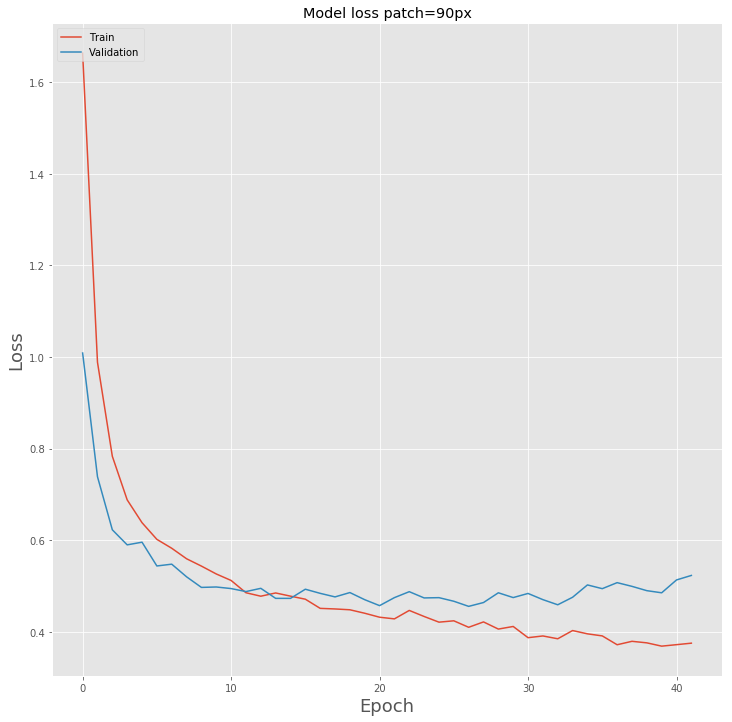

In [47]:
for model_folder in models:
    print(model_folder)
    history = np.load(os.path.join(model_folder,'history.npy')).tolist()
    p_size = int(model_folder.split("-")[1])
    
    plt.clf()
    plt.figure(figsize=(12,12))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy patch=%spx' %p_size)
    plt.ylabel('Accuracy', fontsize=18)
    plt.xlabel('Epoch', fontsize=18)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.gcf().savefig(os.path.join(model_folder, "accuracy patch=%spx.png" %p_size))
    
    plt.clf()
    plt.figure(figsize=(12,12))
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss patch=%spx' %p_size)
    plt.ylabel('Loss', fontsize=18)
    plt.xlabel('Epoch', fontsize=18)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(os.path.join(model_folder, "loss patch=%spx.png" %p_size))
    